<a href="https://colab.research.google.com/github/eshansurendra/EN3160_Assignment_03/blob/main/A03_E01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 30.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Given Sample Code Run Attempt

In [3]:
# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases
w = torch.randn(Din, K) * std  # One layer: directly map input to output
b = torch.zeros(K)

# Hyperparameters
iterations = 20
lr = 2e-6  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []

In [4]:
# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot encoding

        # Forward pass
        y_pred = x_train.mm(w) + b  # Output layer activation

        # Loss calculation (Mean Squared Error with regularization)
        loss = (1 / Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * torch.sum(w ** 2)
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dw = x_train.t().mm(dy_pred) + reg * w
        db = dy_pred.sum(dim=0)

        # Parameter update
        w -= lr * dw
        b -= lr * db

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1}/{iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1/20, Loss: 0.9769272465109825
Epoch 2/20, Loss: 0.9498212249875069
Epoch 3/20, Loss: 0.9360911732316017
Epoch 4/20, Loss: 0.9275490470528602
Epoch 5/20, Loss: 0.9216118362545968
Epoch 6/20, Loss: 0.9172068119645119
Epoch 7/20, Loss: 0.9137930574417115
Epoch 8/20, Loss: 0.9110642638206482
Epoch 9/20, Loss: 0.9088338066339493
Epoch 10/20, Loss: 0.9069805561900138
Epoch 11/20, Loss: 0.905420168042183
Epoch 12/20, Loss: 0.9040930240750312
Epoch 13/20, Loss: 0.9029543214440345
Epoch 14/20, Loss: 0.9019707384109497
Epoch 15/20, Loss: 0.9011168321967125
Epoch 16/20, Loss: 0.9003716661334038
Epoch 17/20, Loss: 0.8997190827727318
Epoch 18/20, Loss: 0.8991455644965172
Epoch 19/20, Loss: 0.8986400582194328
Epoch 20/20, Loss: 0.8981934612989426


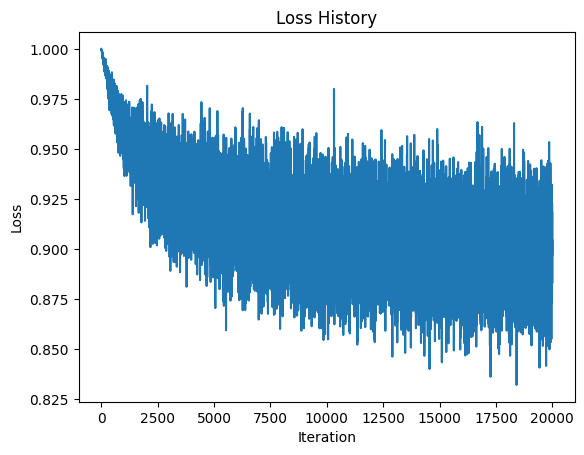

In [5]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [6]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)

        # Forward pass
        y_train_pred = x_train.mm(w) + b
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")


Training accuracy: 32.22%


In [7]:
# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)

        # Forward pass
        y_test_pred = x_test.mm(w) + b
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 32.37%


## Modified code - middle layer with 100 nodes and a sigmoid activation used cross-entropy loss

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
H = 100  # Number of nodes in hidden layer
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5

# Initialize weights and biases for both layers and move them to the GPU
w1 = torch.randn(Din, H, device=device) * std  # Input to hidden layer weights
b1 = torch.zeros(H, device=device)
w2 = torch.randn(H, K, device=device) * std  # Hidden to output layer weights
b2 = torch.zeros(K, device=device)

# Hyperparameters
epochs = 10
lr = 1e-3  # Learning rate
lr_decay = 0.9  # Learning rate decay
reg = 0  # Regularization
loss_history = []

# Define cross-entropy loss function
def cross_entropy_loss(y_pred, y_true):
    return -torch.sum(y_true * torch.log(y_pred + 1e-9)) / y_true.shape[0]

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


# 3. Training Loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels and move them to the GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float() # Convert labels to one-hot encoding

        # Forward pass: Layer 1
        hidden_layer = torch.sigmoid(x_train.mm(w1) + b1)

        # Forward pass: Layer 2 (output layer)
        y_pred = torch.softmax(hidden_layer.mm(w2) + b2, dim = 1)  # Output layer activation

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = cross_entropy_loss(y_pred, y_train_onehot) + reg * (torch.sum(w1**2) + torch.sum(w2**2))
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = y_pred - y_train_onehot
        dw2 = hidden_layer.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)
        dhidden = dy_pred.mm(w2.t()) * hidden_layer * (1 - hidden_layer)
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for every epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay


Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 2.157102610707283
Epoch 2/10, Loss: 1.8975667948722839
Epoch 3/10, Loss: 1.8007661818265914
Epoch 4/10, Loss: 1.745392415881157
Epoch 5/10, Loss: 1.7077248120307922
Epoch 6/10, Loss: 1.6809421886205673
Epoch 7/10, Loss: 1.660348942756653
Epoch 8/10, Loss: 1.6424172828197479
Epoch 9/10, Loss: 1.6266672060489655
Epoch 10/10, Loss: 1.613416032910347


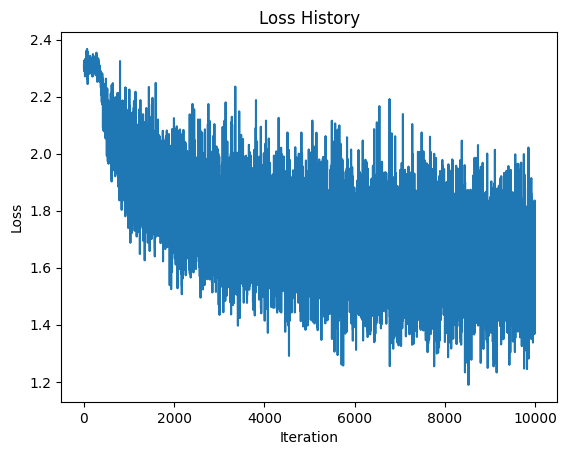

In [24]:
# 4. Plotting the Loss History
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [28]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)

        # Forward pass
        hidden_output = sigmoid(x_train.mm(w1) + b1)
        y_train_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 44.38%


In [27]:
# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)

        # Forward pass
        hidden_output = sigmoid(x_test.mm(w1) + b1)
        y_test_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 43.70%
